<a href="https://colab.research.google.com/github/MassilGG/deep-lob-gan/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE: cuda


In [2]:
!git clone https://github.com/MassilGG/deep-lob-gan

fatal: destination path 'deep-lob-gan' already exists and is not an empty directory.


In [3]:
!cd deep-lob-gan

In [4]:
!git pull

fatal: not a git repository (or any of the parent directories): .git


# 1) Load LOBSTER files

In [5]:
name = "MSFT_2012-06-21_34200000_57600000"
book_path = f"/content/deep-lob-gan/data/{name}_orderbook_5.csv"   # <-- change
msg_path  = f"/content/deep-lob-gan/data/{name}_message_5.csv"     # <-- change (recommended). If missing, set msg_path=None

DATA_LEVELS = 5  # you said 5 levels
LEVELS = 3
DT_SEC = 1 # paper uses 10s; with 1 day only, consider 1-5s if too few samples
DROP_OPEN_MIN = 30
DROP_CLOSE_MIN = 30


def read_lobster_book(path, levels=5, sep=","):
    """
    Reads LOBSTER orderbook file without header.
    Common format (per level): ask_price_i, ask_size_i, bid_price_i, bid_size_i, repeated for i=1..levels
    => total columns = 4*levels
    """
    df = pd.read_csv(path, header=None, sep=sep)
    expected = 4 * levels
    if df.shape[1] != expected:
        raise ValueError(f"Expected {expected} columns for {levels} levels, got {df.shape[1]}. "
                         "Check sep delimiter or file format.")
    return df

def read_lobster_message(path, sep=","):
    """
    Typical LOBSTER message columns:
    0: time (seconds after midnight, float)
    1: event type
    2: order id
    3: size
    4: price
    5: direction
    """
    df = pd.read_csv(path, header=None, sep=sep)
    if df.shape[1] < 1:
        raise ValueError("Message file seems empty or badly parsed.")
    return df

# Try comma first, fallback to space
def smart_read_book(path, levels=5):
    for sep in [",", r"\s+"]:
        try:
            return read_lobster_book(path, levels=levels, sep=sep)
        except Exception as e:
            last = e
    raise last

def smart_read_msg(path):
    for sep in [",", r"\s+"]:
        try:
            return read_lobster_message(path, sep=sep)
        except Exception as e:
            last = e
    raise last

msg_df = smart_read_msg(msg_path)
time_sec = msg_df.iloc[:, 0].astype(float).values
book_df = smart_read_book(book_path, levels=DATA_LEVELS)
book_df = book_df.iloc[:, :LEVELS*4].copy()
print("book_df shape:", book_df.shape)
print("time range (sec):", float(time_sec[0]), "->", float(time_sec[-1]))


book_df shape: (595800, 12)
time range (sec): 34200.01399412 -> 57599.907796528


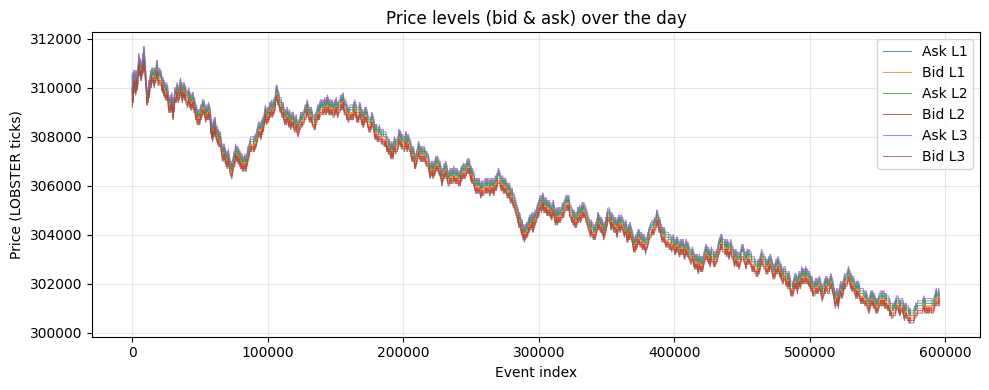

In [6]:
# Visualisation
plt.figure(figsize=(10, 4))

for i in range(LEVELS):
    ask_p = book_df.iloc[:, 4*i].values
    bid_p = book_df.iloc[:, 4*i + 2].values

    plt.plot(ask_p, alpha=0.8, linewidth=0.7,
        label=f"Ask L{i+1}")
    plt.plot(bid_p,alpha=0.8,linewidth=0.7,
        label=f"Bid L{i+1}")

plt.title("Price levels (bid & ask) over the day")
plt.xlabel("Event index")
plt.ylabel("Price (LOBSTER ticks)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 2) Resample to regular Δt grid

In [7]:
def resample_book_last_in_bin(book_df, time_sec, dt_sec=10):
    """
    Creates a regular time grid and keeps the last snapshot observed in each bin.
    """
    t0, t1 = float(time_sec[0]), float(time_sec[-1])
    grid = np.arange(t0, t1 + 1e-9, dt_sec)
    idx = np.searchsorted(time_sec, grid, side="right") - 1
    idx[idx < 0] = 0
    idx[idx >= len(book_df)] = len(book_df) - 1
    resampled = book_df.iloc[idx].reset_index(drop=True)
    return resampled, grid


book_res, grid_sec = resample_book_last_in_bin(book_df, time_sec, dt_sec=DT_SEC)

# Drop first/last 30 minutes of continuous trading session (paper-style)
# Here we do it purely in clock time:
open_cut = DROP_OPEN_MIN * 60
close_cut = DROP_CLOSE_MIN * 60
mask = (grid_sec >= grid_sec[0] + open_cut) & (grid_sec <= grid_sec[-1] - close_cut)
book_res = book_res.loc[mask].reset_index(drop=True)
grid_sec = grid_sec[mask]

print("Resampled shape:", book_res.shape)

Resampled shape: (19800, 12)


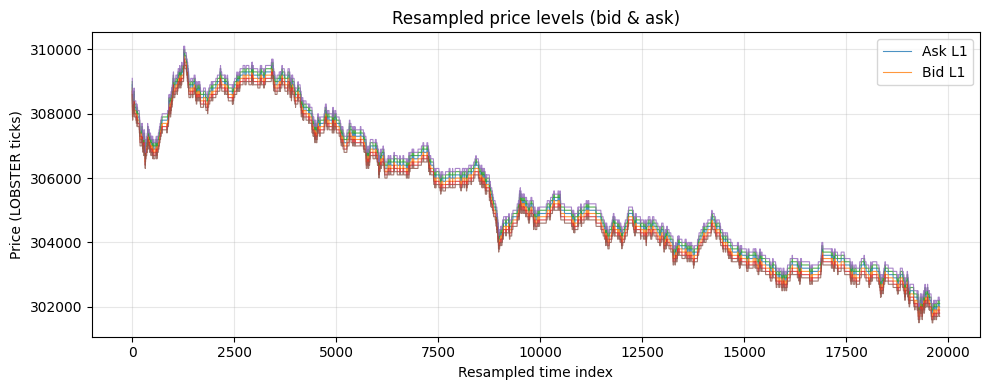

In [8]:
# Visualisation
plt.figure(figsize=(10, 4))

for i in range(LEVELS):
    ask_p = book_res.iloc[:, 4*i].values
    bid_p = book_res.iloc[:, 4*i + 2].values

    plt.plot(
        ask_p,
        alpha=0.8,
        linewidth=0.8,
        label=f"Ask L{i+1}" if i == 0 else None
    )
    plt.plot(
        bid_p,
        alpha=0.8,
        linewidth=0.8,
        label=f"Bid L{i+1}" if i == 0 else None
    )

plt.title("Resampled price levels (bid & ask)")
plt.xlabel("Resampled time index")
plt.ylabel("Price (LOBSTER ticks)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# **3**)LOB Representation

Build "centered snapshot" vector X_t of length 2L (L=LEVELS) using a price grid fixed at time t:
- grid_prices_t = [bidP_L..bidP1, askP1..askP_L]
- X_t = [ -bidS_L..-bidS1, +askS1..+askS_L ]
- X_{t+dt} is computed on the SAME grid_prices_t by looking up sizes at t+dt (missing => 0).


In [9]:
def parse_level_columns(row, levels=5):
    """
    Returns arrays (askP, askS, bidP, bidS) each length=levels.
    Handles the common interleaved format:
      [askP1, askS1, bidP1, bidS1, askP2, askS2, bidP2, bidS2, ...]
    If your file is different, adapt here.
    """
    arr = row.values.astype(float)
    askP, askS, bidP, bidS = [], [], [], []
    for i in range(levels):
        base = 4*i
        askP.append(arr[base + 0])
        askS.append(arr[base + 1])
        bidP.append(arr[base + 2])
        bidS.append(arr[base + 3])
    return np.array(askP), np.array(askS), np.array(bidP), np.array(bidS)

def snapshot_on_own_grid(row, levels=5):
    askP, askS, bidP, bidS = parse_level_columns(row, levels=levels)
    # grid prices: bids from deep->best, then asks best->deep
    grid_prices = np.concatenate([bidP[::-1], askP])
    # signed sizes aligned with that grid
    x = np.concatenate([-bidS[::-1], +askS])
    return grid_prices, x

def snapshot_on_given_grid(row, grid_prices, levels=5):
    askP, askS, bidP, bidS = parse_level_columns(row, levels=levels)
    # map price -> signed size (only top levels available)
    mp = {}
    for i in range(levels):
        mp[float(bidP[i])] = -float(bidS[i])
        mp[float(askP[i])] = +float(askS[i])
    x = np.array([mp.get(float(p), 0.0) for p in grid_prices], dtype=float)
    return x

# Build pairs (S_t, X_{t+1}) where S_t = X_t (Markov)
X_list, Y_list = [], []
for t in range(len(book_res) - 1):
    grid_prices_t, x_t = snapshot_on_own_grid(book_res.iloc[t], levels=LEVELS)
    x_next_on_grid_t = snapshot_on_given_grid(book_res.iloc[t+1], grid_prices_t, levels=LEVELS)
    X_list.append(x_t)
    Y_list.append(x_next_on_grid_t)

X = np.stack(X_list)  # (N-1, 2k)
Y = np.stack(Y_list)  # (N-1, 2k)
print("X,Y shapes:", X.shape, Y.shape)

X,Y shapes: (19799, 6) (19799, 6)


3bis) Visualisation of the X,y Data

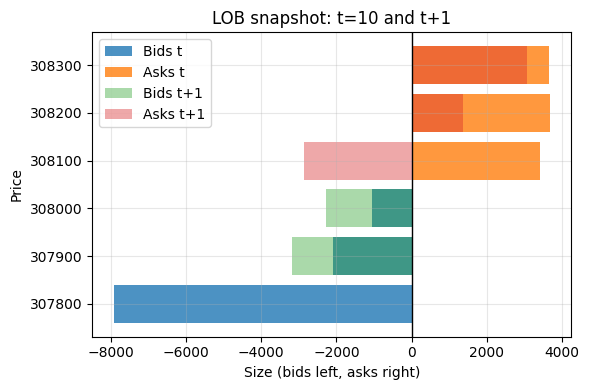

In [10]:
t = 10

# --- x_t on its own grid ---
grid_prices, x_t = snapshot_on_own_grid(book_res.iloc[t], levels=LEVELS)

# --- y_t = x_{t+1} mapped onto grid(t) ---
y_t = snapshot_on_given_grid(book_res.iloc[t+1], grid_prices, levels=LEVELS)

k = len(grid_prices) // 2

# --- build tables ---
lob_x = pd.DataFrame({
    "price": grid_prices,
    "bid": np.r_[ -x_t[:k], np.zeros(k) ],
    "ask": np.r_[ np.zeros(k),  x_t[k:] ]
})

lob_y = pd.DataFrame({
    "price": grid_prices,
    "bid": np.r_[ -y_t[:k], np.zeros(k) ],
    "ask": np.r_[ np.zeros(k),  y_t[k:] ]
})

tick = np.min(np.diff(np.unique(grid_prices)))

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

# --- x_t (current state) ---
ax.barh(lob_x["price"], -lob_x["bid"], height=0.8 * tick,
        alpha=0.8, label="Bids t")
ax.barh(lob_x["price"],  lob_x["ask"], height=0.8 * tick,
        alpha=0.8, label="Asks t")

# --- y_t (next state) ---
ax.barh(lob_y["price"], -lob_y["bid"], height=0.8 * tick,
        alpha=0.4, linestyle="--", label="Bids t+1")
ax.barh(lob_y["price"],  lob_y["ask"], height=0.8 * tick,
        alpha=0.4, linestyle="--", label="Asks t+1")

ax.axvline(0, color="black", linewidth=1)
ax.set_xlabel("Size (bids left, asks right)")
ax.set_ylabel("Price")
ax.set_title(f"LOB snapshot: t={t} and t+1")
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


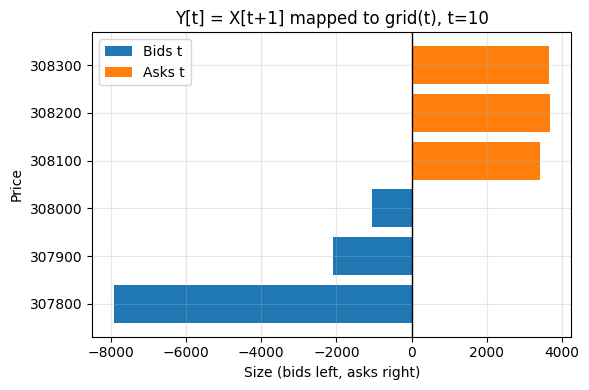

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.barh(lob_x["price"], -lob_x["bid"], height=0.8 * tick, label="Bids t")
ax.barh(lob_x["price"],  lob_x["ask"], height=0.8 * tick, label="Asks t")

ax.axvline(0, color="black", linewidth=1)
ax.set_xlabel("Size (bids left, asks right)")
ax.set_ylabel("Price")
ax.set_title(f"Y[t] = X[t+1] mapped to grid(t), t={t}")
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()


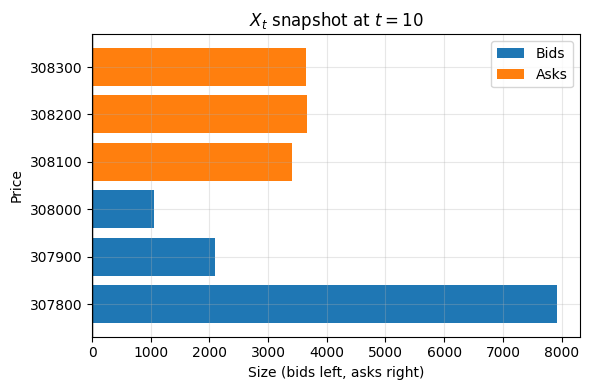

In [12]:
plt.figure(figsize=(6, 4))

# bids (left)
plt.barh(grid_prices[:k], -x_t[:k], height=0.8 * tick, label="Bids")

# asks (right)
plt.barh(grid_prices[k:],  x_t[k:], height=0.8 * tick, label="Asks")

plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Size (bids left, asks right)")
plt.ylabel("Price")
plt.title(r"$X_t$ snapshot at $t=10$")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

4) Signed-sqrt normalization (paper Eq. (18))

x_norm = sign(x)*sqrt(|x|)/c

In [13]:
def signed_sqrt_norm(x, c):
    return np.sign(x) * np.sqrt(np.abs(x)) / c

def signed_sqrt_inv(xn, c):
    return np.sign(xn) * (np.abs(xn) * c)**2

# choose c from training data scale (robust)
abs_sqrt = np.sqrt(np.abs(np.concatenate([X.flatten(), Y.flatten()])))
c = np.percentile(abs_sqrt, 99.5) + 1e-8
print("Normalization constant c =", c)

Xn = signed_sqrt_norm(X, c).astype(np.float32)
Yn = signed_sqrt_norm(Y, c).astype(np.float32)

Normalization constant c = 177.46267214135275


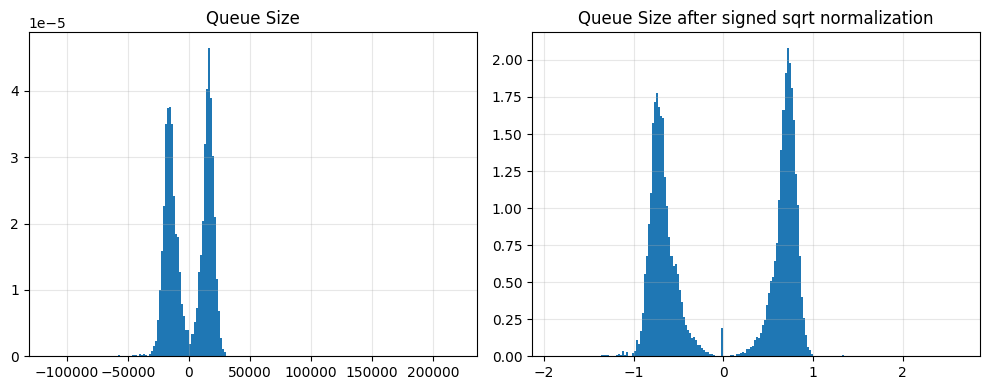

In [14]:
raw = np.concatenate([X.flatten(), Y.flatten()])
normed = signed_sqrt_norm(raw, c)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(raw, bins=200,density=True)
axs[0].set_title("Queue Size")
axs[0].grid(alpha=0.3)

axs[1].hist(normed, bins=200,density=True)
axs[1].set_title("Queue Size after signed sqrt normalization")
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


5) Train/val split

In [27]:
N = len(Xn)
perm = np.random.permutation(N)
split = int(0.9 * N)
tr_idx, va_idx = perm[:split], perm[split:]

Xtr, Ytr = Xn[tr_idx], Yn[tr_idx]
Xva, Yva = Xn[va_idx], Yn[va_idx]
print("Train:", Xtr.shape, "Val:", Xva.shape)

Train: (17819, 6) Val: (1980, 6)


In [28]:
k = LEVELS
zero_per_feat = (np.abs(Y) < 1e-12).mean(axis=0)
print("Zero rate per feature:", zero_per_feat)

print("Avg zero bid side:", zero_per_feat[:k].mean(), "ask side:", zero_per_feat[k:].mean())
for i in range(k):
    print(f"level {k-i} bid:", zero_per_feat[i], "| level {i+1} ask:", zero_per_feat[k+i])

Zero rate per feature: [0.02282944 0.00101015 0.00176777 0.0006566  0.00146472 0.02479923]
Avg zero bid side: 0.008535784635587655 ask side: 0.008973517181002408
level 3 bid: 0.022829435830092427 | level {i+1} ask: 0.0006565988181221273
level 2 bid: 0.001010152027880196 | level {i+1} ask: 0.001464720440426284
level 1 bid: 0.001767766048790343 | level {i+1} ask: 0.02479923228445881


## II. Model
### 6) Torch Dataset

In [29]:
class LobTransitionDataset(Dataset):
    def __init__(self, Xcond, Ytarget):
        self.X = torch.from_numpy(Xcond)
        self.Y = torch.from_numpy(Ytarget)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.Y[i]

BATCH_SIZE = 512 if len(Xtr) >= 2048 else 128
train_loader = DataLoader(LobTransitionDataset(Xtr, Ytr), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(LobTransitionDataset(Xva, Yva), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


### 7) Conditional WGAN-GP (paper Section 4, Eq. (15))

In [36]:
DIM_X = 2 * LEVELS
DIM_S = DIM_X
DIM_Z = 16

class Generator(nn.Module):
    def __init__(self, dim_z, dim_s, dim_x, h1=64, h2=64):
        super().__init__()
        self.z_net = nn.Sequential(
            nn.Linear(dim_z, h1), nn.ReLU(),
            nn.Linear(h1, h2), nn.ReLU(),
        )
        self.s_net = nn.Sequential(
            nn.Linear(dim_s, h1), nn.ReLU(),
            nn.Linear(h1, h2), nn.ReLU(),
        )
        self.out = nn.Sequential(
            nn.Linear(h2 + h2, h2), nn.ReLU(),
            nn.Linear(h2, dim_x)  # linear output (sizes can be +/-)
        )

    def forward(self, z, s):
        hz = self.z_net(z)
        hs = self.s_net(s)
        h = torch.cat([hz, hs], dim=1)
        return self.out(h)

class Critic(nn.Module):
    def __init__(self, dim_x, dim_s, h=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim_x + dim_s, h), nn.ReLU(),
            nn.Linear(h, h), nn.ReLU(),
            nn.Linear(h, 1)
        )
    def forward(self, x, s):
        return self.net(torch.cat([x, s], dim=1))

G = Generator(DIM_Z, DIM_S, DIM_X).to(DEVICE)
D = Critic(DIM_X, DIM_S).to(DEVICE)

# Hyperparams (you can tune)
LRG = 1e-5   # paper used ~1e-5 on much larger data; 1-day data usually needs faster learning
LRD = 2e-5
BETAS = (0.0, 0.9)
LAMBDA_GP = 10.0
N_CRITIC = 3
GRAD_CLIP_VALUE = 1.0  # critic gradient clipping "by value" (paper mentions clipping to stabilize)

optG = optim.Adam(G.parameters(), lr=LRG, betas=BETAS)
optD = optim.Adam(D.parameters(), lr=LRD, betas=BETAS)

def gradient_penalty(D, real_x, fake_x, s):
    """
    GP on interpolations between real and fake (WGAN-GP).
    """
    bs = real_x.size(0)
    eps = torch.rand(bs, 1, device=DEVICE)
    xhat = eps * real_x + (1 - eps) * fake_x
    xhat.requires_grad_(True)
    dhat = D(xhat, s)
    grad = torch.autograd.grad(
        outputs=dhat, inputs=xhat,
        grad_outputs=torch.ones_like(dhat),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    gp = ((grad.norm(2, dim=1) - 1.0) ** 2).mean()
    return gp

@torch.no_grad()
def eval_basic_metrics(G, loader, n_batches=3):
    G.eval()
    reals, fakes = [], []
    for i, (s, y) in enumerate(loader):
        if i >= n_batches: break
        s = s.to(DEVICE)
        y = y.to(DEVICE)
        z = torch.randn(s.size(0), DIM_Z, device=DEVICE)
        yhat = G(z, s)
        reals.append(y.cpu().numpy())
        fakes.append(yhat.cpu().numpy())
    reals = np.concatenate(reals, axis=0)
    fakes = np.concatenate(fakes, axis=0)
    return {
        "real_mean": float(reals.mean()),
        "fake_mean": float(fakes.mean()),
        "real_std":  float(reals.std()),
        "fake_std":  float(fakes.std()),
    }

#### 8) Training loop

In [31]:
@torch.no_grad()
def generate_fake(G, Xcond, dim_z, device, batch_size=2048):
    G.eval()
    out = []
    n = len(Xcond)
    for i in range(0, n, batch_size):
        s = torch.from_numpy(Xcond[i:i+batch_size]).to(device)
        z = torch.randn(s.size(0), dim_z, device=device)
        y = G(z, s).cpu().numpy()
        out.append(y)
    return np.vstack(out)

fake_va = generate_fake(G, Xva, DIM_Z, DEVICE)
real_va = Yva[:len(fake_va)]
print("real_va:", real_va.shape, "fake_va:", fake_va.shape)


real_va: (1980, 6) fake_va: (1980, 6)


In [32]:
EPOCHS = 250   # small data -> more epochs
SIGMA = 0.0003
print_every = 5

loss_hist = {"D": [], "G": [], "gp": [], "w": []}

def corr_error(real, fake):
    Cr = np.corrcoef(real, rowvar=False)
    Cf = np.corrcoef(fake, rowvar=False)
    return np.linalg.norm(Cf - Cr)

def lob_shape_error(real, fake, levels):
    # compare mean depths (best->deep) on bid+ask
    def mean_depth(Y):
        bid = -Y[:, :levels][:, ::-1]
        ask =  Y[:, levels:2*levels]
        return np.concatenate([bid.mean(0), ask.mean(0)])
    return np.linalg.norm(mean_depth(fake) - mean_depth(real))

# inside training, every K epochs:
K = 5

for epoch in range(1, EPOCHS + 1):
    G.train(); D.train()
    for (s, y_real) in train_loader:
        s = s.to(DEVICE)
        y_real = y_real.to(DEVICE)

        # --- Train critic N_CRITIC steps ---
        for _ in range(N_CRITIC):
            z = torch.randn(s.size(0), DIM_Z, device=DEVICE)
            y_fake = G(z, s).detach()

            # >>> ADD NOISE HERE (right before D calls) <<<
            y_real_noisy = y_real + SIGMA * torch.randn_like(y_real)
            y_fake_noisy = y_fake + SIGMA * torch.randn_like(y_fake)

            D_real = D(y_real_noisy, s).mean()
            D_fake = D(y_fake_noisy, s).mean()
            #D_real = D(y_real, s).mean()
            #D_fake = D(y_fake, s).mean()
            w_dist = D_real - D_fake  # maximize this
            gp = gradient_penalty(D, y_real_noisy, y_fake_noisy, s)
            lossD = -(w_dist) + LAMBDA_GP * gp

            optD.zero_grad(set_to_none=True)
            lossD.backward()
            if GRAD_CLIP_VALUE is not None:
                for p in D.parameters():
                    if p.grad is not None:
                        p.grad.data.clamp_(-GRAD_CLIP_VALUE, GRAD_CLIP_VALUE)
            optD.step()

        # --- Train generator ---
        z = torch.randn(s.size(0), DIM_Z, device=DEVICE)
        y_fake = G(z, s)
        lossG = -D(y_fake, s).mean()  # minimize -E[D(fake)]
        optG.zero_grad(set_to_none=True)
        lossG.backward()
        optG.step()

        loss_hist["D"].append(float(lossD.detach().cpu()))
        loss_hist["G"].append(float(lossG.detach().cpu()))
        loss_hist["gp"].append(float(gp.detach().cpu()))
        loss_hist["w"].append(float(w_dist.detach().cpu()))

    if epoch % print_every == 0:
        metrics = eval_basic_metrics(G, val_loader, n_batches=3)
        print(f"Epoch {epoch:03d}/{EPOCHS} | "
              f"D {np.mean(loss_hist['D'][-len(train_loader):]):.3f} | "
              f"G {np.mean(loss_hist['G'][-len(train_loader):]):.3f} | "
              f"W {np.mean(loss_hist['w'][-len(train_loader):]):.3f} | "
              f"val mean(real/fake) {metrics['real_mean']:.3f}/{metrics['fake_mean']:.3f} | "
              f"val std(real/fake) {metrics['real_std']:.3f}/{metrics['fake_std']:.3f}")
    if epoch % K == 0:
      fake_va = generate_fake(G, Xva, DIM_Z, DEVICE, batch_size=2048)
      real_va = Yva[:len(fake_va)]
      print("corr_err:", corr_error(real_va, fake_va),
            "lob_shape_err:", lob_shape_error(real_va, fake_va, LEVELS))



Epoch 005/250 | D 1.742 | G 0.251 | W 0.022 | val mean(real/fake) 0.008/0.046 | val std(real/fake) 0.699/0.112
corr_err: 2.7922623971534293 lob_shape_err: 1.5417393
Epoch 010/250 | D -0.596 | G 0.252 | W 0.642 | val mean(real/fake) 0.008/0.045 | val std(real/fake) 0.699/0.145
corr_err: 2.932031926814254 lob_shape_err: 1.507171
Epoch 015/250 | D -1.242 | G 0.136 | W 1.292 | val mean(real/fake) 0.008/0.042 | val std(real/fake) 0.699/0.184
corr_err: 2.9884325262220965 lob_shape_err: 1.4186518
Epoch 020/250 | D -1.364 | G -0.043 | W 1.417 | val mean(real/fake) 0.008/0.037 | val std(real/fake) 0.699/0.224
corr_err: 2.823836070121021 lob_shape_err: 1.3067718
Epoch 025/250 | D -1.237 | G -0.125 | W 1.278 | val mean(real/fake) 0.008/0.036 | val std(real/fake) 0.699/0.270
corr_err: 2.517758156129554 lob_shape_err: 1.170962
Epoch 030/250 | D -1.083 | G -0.204 | W 1.113 | val mean(real/fake) 0.008/0.039 | val std(real/fake) 0.699/0.333
corr_err: 2.475189833942305 lob_shape_err: 1.0094608
Epoch 03

### 9) Quick diagnostics: losses + marginal distributions


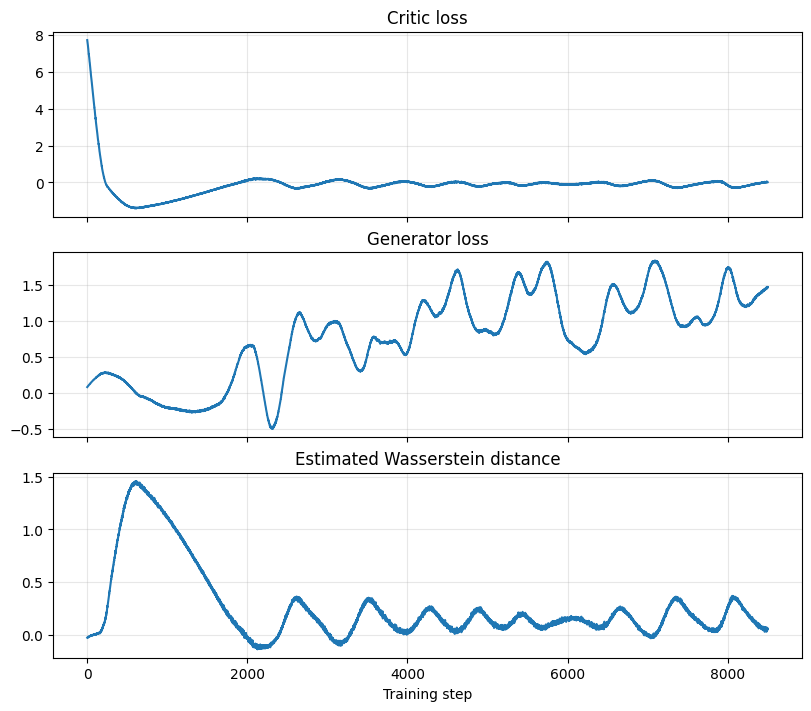

In [40]:
fig, axs = plt.subplots(3, 1, figsize=(8, 7), sharex=True, constrained_layout=True)

axs[0].plot(loss_hist["D"])
axs[0].set_title("Critic loss")
axs[0].grid(alpha=0.3)

axs[1].plot(loss_hist["G"])
axs[1].set_title("Generator loss")
axs[1].grid(alpha=0.3)

axs[2].plot(loss_hist["w"])
axs[2].set_title("Estimated Wasserstein distance")
axs[2].set_xlabel("Training step")
axs[2].grid(alpha=0.3)

plt.show()


## III. Evaluation




### 1) Marginal distribution density: real vs fake
(a) Quick version: hist density overlays (robust)

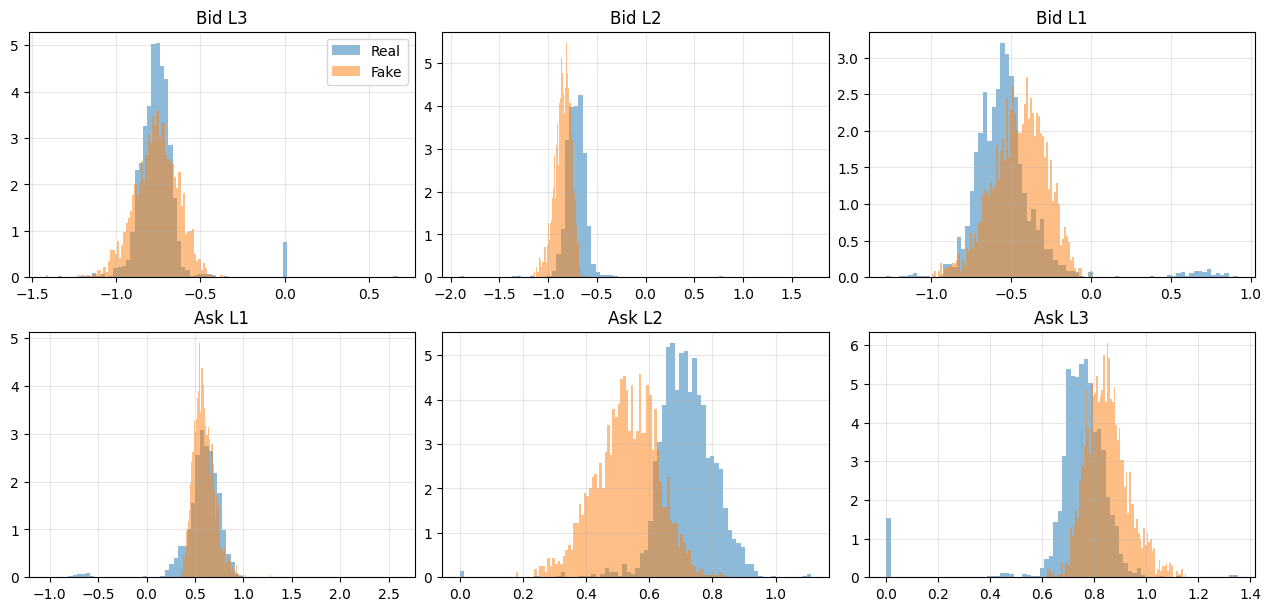

In [35]:
k = LEVELS
k2 = 2 * k

# build feature labels
labels = (
    [f"Bid L{k-i}" for i in range(k)] +
    [f"Ask L{i+1}" for i in range(k)]
)

fig, axs = plt.subplots(2, k, figsize=(4.2*k, 6), constrained_layout=True)
axs = axs.ravel()

for j in range(k2):
    ax = axs[j]
    ax.hist(real_va[:, j], bins=80, density=True, alpha=0.5, label="Real")
    ax.hist(fake_va[:, j], bins=80, density=True, alpha=0.5, label="Fake")
    ax.set_title(labels[j])
    ax.grid(True, alpha=0.3)
    if j == 0:
        ax.legend()

plt.show()


### LOB Shape

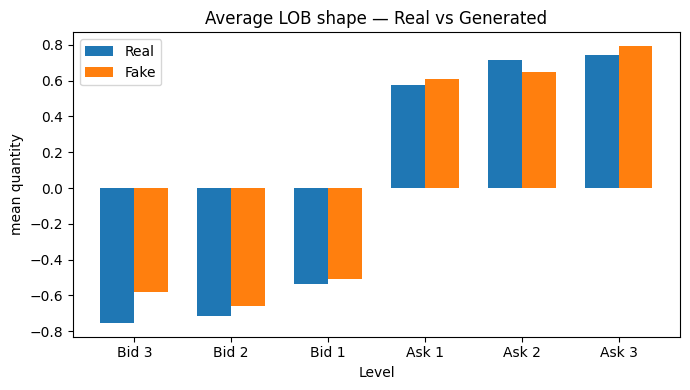

In [23]:
k = LEVELS

# --- average shape over samples ---
avg_real = real_va.mean(axis=0)
avg_fake = fake_va.mean(axis=0)

# --- labels ---
labels = (
    [f"Bid {k-i}" for i in range(k)] +
    [f"Ask {i+1}" for i in range(k)]
)

x = np.arange(2 * k)
width = 0.35

plt.figure(figsize=(7, 4))

plt.bar(x - width/2,avg_real,width,label="Real")

plt.bar(x + width/2,avg_fake,width,label="Fake")

plt.xticks(x, labels)
plt.xlabel("Level")
plt.ylabel("mean quantity")
plt.title("Average LOB shape — Real vs Generated")
plt.legend()

plt.tight_layout()
plt.show()


Correlations

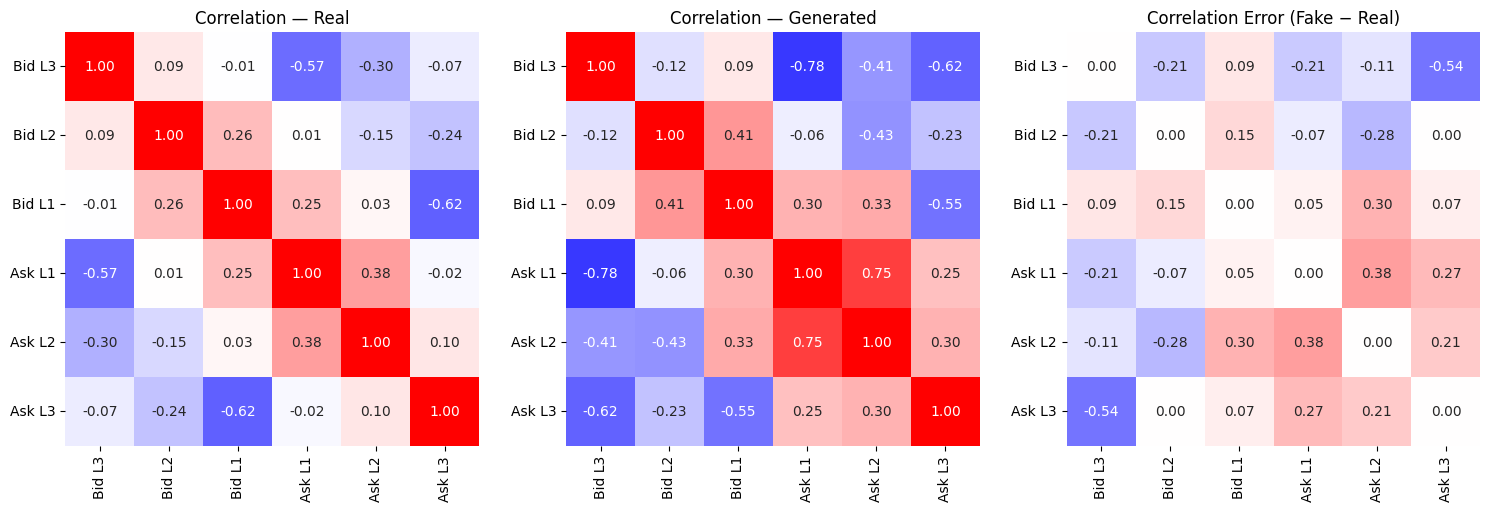

In [24]:
real = np.asarray(real_va)
fake = np.asarray(fake_va)

def corr_mat(X):
    return np.corrcoef(X, rowvar=False)

C_real = corr_mat(real)
C_fake = corr_mat(fake)
C_diff = C_fake - C_real

# Feature labels
labels = (
    [f"Bid L{LEVELS-i}" for i in range(LEVELS)] +
    [f"Ask L{i+1}" for i in range(LEVELS)]
)

k = LEVELS
m = np.max(np.abs(C_diff))

fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# ---- Real ----
sns.heatmap(C_real,ax=axs[0],vmin=-1, vmax=1,cmap="bwr",
    annot=True, fmt=".2f",xticklabels=labels,yticklabels=labels,
    square=True,cbar=False)
axs[0].set_title("Correlation — Real")

# ---- Fake ----
sns.heatmap(C_fake,ax=axs[1],vmin=-1, vmax=1,cmap="bwr",
    annot=True, fmt=".2f",xticklabels=labels,yticklabels=labels,
    square=True,cbar=False)
axs[1].set_title("Correlation — Generated")

# ---- Difference ----
sns.heatmap(C_diff,ax=axs[2],vmin=-1, vmax=1,cmap="bwr",
    annot=True, fmt=".2f",xticklabels=labels,yticklabels=labels,
    square=True,cbar=False)
axs[2].set_title("Correlation Error (Fake − Real)")

for ax in axs:
    ax.tick_params(axis="x", rotation=90)
    ax.tick_params(axis="y", rotation=0)

plt.show()
